# Efficiency of Peak Detection Methods

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
%%capture
import sys
sys.path.insert(0, '/home/raf_pc/Kemal/RiboSeqAnalysis')
from infrastructure.main import *

# Working environment
temp_repo_dir = "/home/raf_pc/Kemal/Temp"
data_repo_dir = "/home/raf_pc/Kemal/Data"

# SAM files for ribosome stalling data and coco assembly data
spt = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_TT1.sam", "60mer_TT2.sam"]]
sps = [os.path.join(data_repo_dir, "Sixtymers", i) for i in ["60mer_Rep1.sam", "60mer_Rep2.sam", "60mer_NoPK.sam"]]

# Exculude the gene below because it has over-expression problem.
exclude_genes = ["ENSG00000160789"]

# Create the infrastructure object
I = Infrastructre(temp_repo_dir,
                  exclude_genes=exclude_genes,
                  riboseq_assign_at=-15,
                  riboseq_assign_to="best_transcript",
                  ensembl_release=102,
                  verbose=True, 
                  sixtymers=[spt, sps])

## Amino Acid Windows

In [3]:
from functools import partial
from copy import deepcopy

window_len = 181
window_flank = int(np.floor(window_len / 2))
percentiles = (60, 70, 80, 85, 90, 92.5, 95, 97.5, 99)
probabilities = (0.120, 0.080, 0.050, 0.025, 0.0175, 0.010, 0.004, 0.0025, 0.001)
assert window_len % 2 == 1 and window_len >= 3
assert len(percentiles) == len(probabilities)

# Methods
inecik1 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_1, window="hanning", window_len=23, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik2 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_2, window="hanning", window_len=23, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik3 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_3, window="hanning", window_len=23, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
inecik4 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_4, window="hanning", window_len=23, wlen=300, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)
arpat = partial(I.riboseq_sixtymers.stalling_peaks_arpat, mmc_threshold=1, normalized_peak_count_thr=5, get_top=5)

save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_protein_sequences_params_percentile.joblib")
try:  # Because it takes very long, as written very inefficiently.
    W = joblib.load(save_metadata_path)
except FileNotFoundError:

    ci = [[] for _ in range(len(percentiles))]
    windows = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), [], []]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo

    for ind, gene_id in enumerate(I.gene_list):
        progress_bar(ind, len(I.gene_list) - 1, verbose=True)
        best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
        protein_sequence = I.protein_genome.db[best_transcript][1]
        length_protein = len(protein_sequence)
        assert "." not in protein_sequence
        protein_sequence = "." * window_flank + protein_sequence + "." * window_flank
        # My methods
        for param1 in range(len(percentiles)):
            peaks1 = (np.floor(inecik1(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            peaks2 = (np.floor(inecik2(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            peaks3 = (np.floor(inecik3(gene_id, probability=probabilities[param1]) / 3) + window_flank).astype(int)
            peaks4 = (np.floor(inecik4(gene_id, percentile=percentiles[param1]) / 3) + window_flank).astype(int)
            for inecik_method, peaks in zip(range(4), [peaks1, peaks2, peaks3, peaks4]):
                for peak in peaks:
                    windows[inecik_method][param1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Arpat
        peaks5 = (np.floor(arpat(gene_id) / 3) + window_flank).astype(int)
        for peak in peaks5:
            windows[4].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
        # Monte Carlo
        peaks_mc = (np.sort(np.random.choice(length_protein, 10)) + window_flank).astype(int)
        for peak in peaks_mc:
            windows[5].append(protein_sequence[peak - window_flank: peak + window_flank + 1])        

    ci = [None for _ in range(len(percentiles))]
    W = [deepcopy(ci), deepcopy(ci), deepcopy(ci), deepcopy(ci), None, None]  # inecik1, inecik2, inecik3, inecik4, arpat, monte_carlo

    for inecik_method in range(4):
        for param1 in range(len(percentiles)):
            W_temp = np.chararray((len(windows[inecik_method][param1]), window_len), itemsize=1)
            W_temp[:] = "."
            for ind, peak_window in enumerate(windows[inecik_method][param1]):
                W_temp[ind] = list(peak_window)
            W[inecik_method][param1] = W_temp
    for other_method in range(4, 6):
        W_temp = np.chararray((len(windows[other_method]), window_len), itemsize=1)
        W_temp[:] = "."
        for ind, peak_window in enumerate(windows[other_method]):
            W_temp[ind] = list(peak_window)
        W[other_method] = W_temp

    del windows
    joblib.dump(W, save_metadata_path)

## Charge

In [4]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
charges = list()
for k in range(4):
    charges_method = list()
    for i in range(len(percentiles)):
        charges_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
            charges_temp.append(average_charge)
        charges_method.append(charges_temp)
    charges.append(charges_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    charges_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_charge = pa.charge_at_pH(7) / len(aminoacids_vertical)
        charges_temp.append(average_charge)
    charges.append(charges_temp)

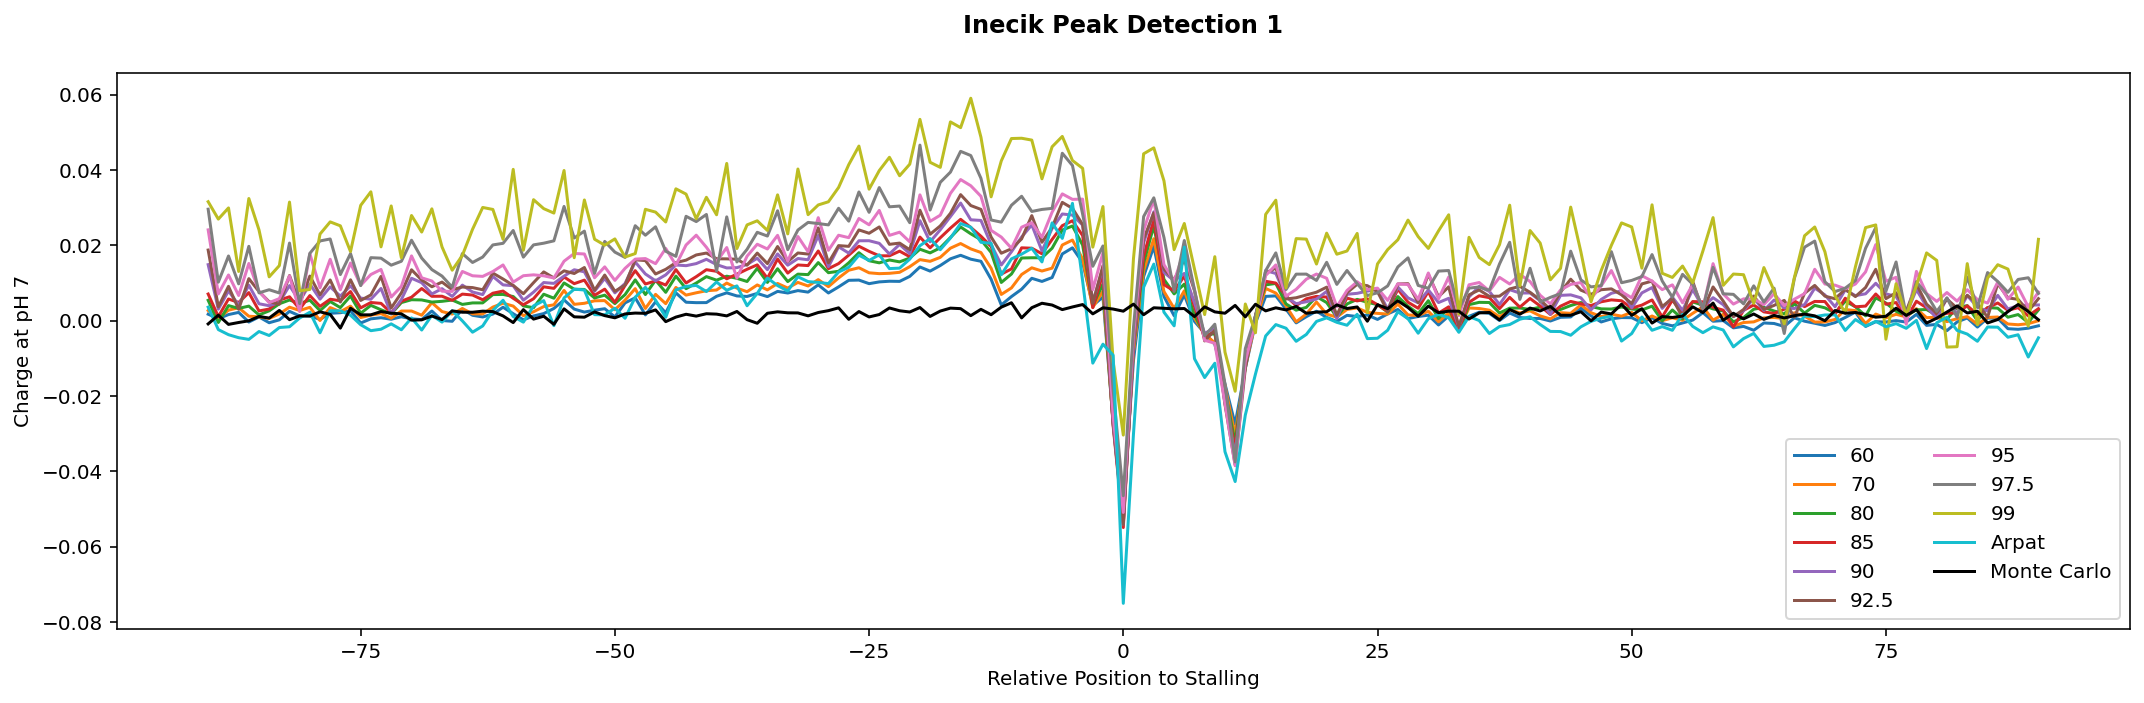

In [5]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, charges[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, charges[4], label="Arpat")
plt.plot(x, charges[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Charge at pH 7")
plt.tight_layout()
plt.show()

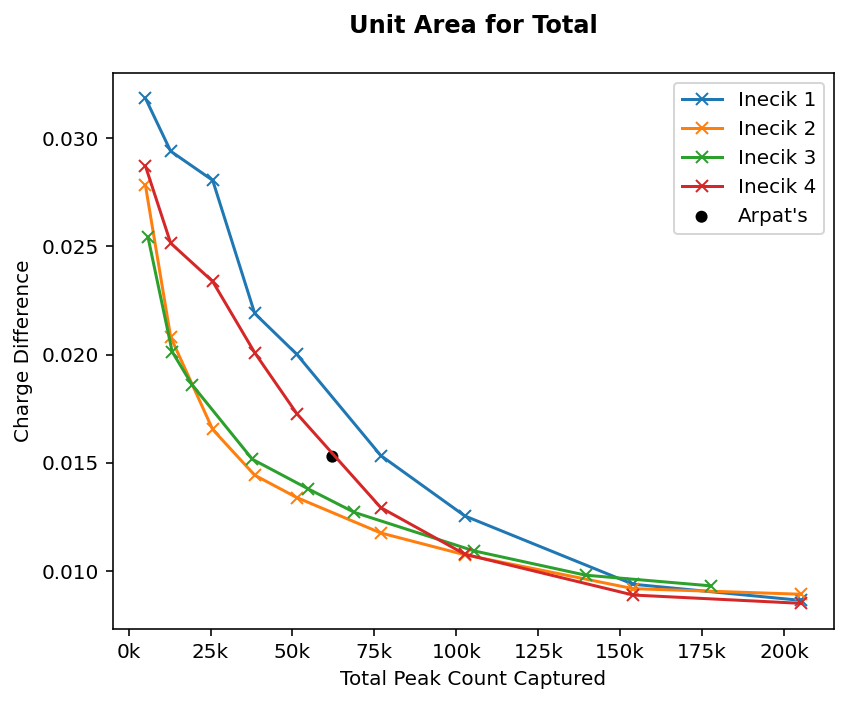

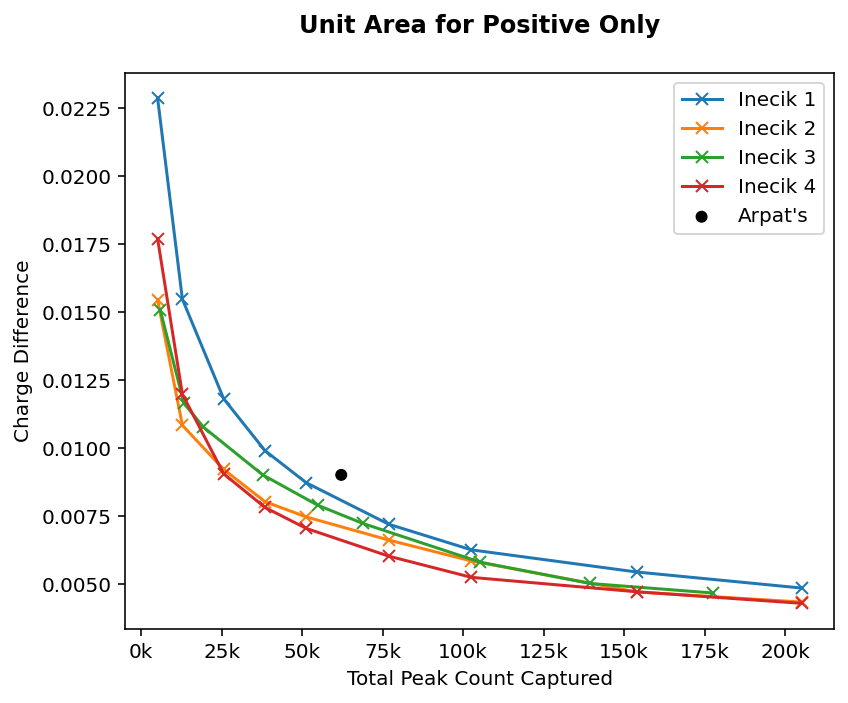

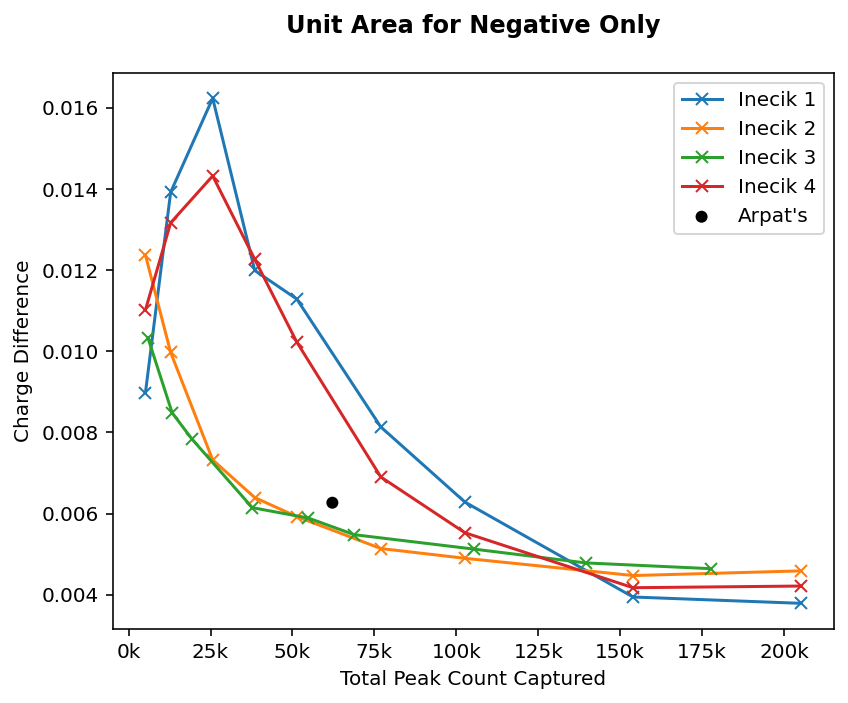

In [6]:
def objective_function(x1, x2, method):
    diff = np.array(x1) - np.array(x2) # calculate difference
    posPart = np.maximum(diff, 0) # only keep positive part, set other values to zero
    negPart = -np.minimum(diff, 0) # only keep negative part, set other values to zero    
    posAreaRatio = np.trapz(posPart) / np.sum(diff > 0)
    negAreaRatio = np.trapz(negPart) / np.sum(diff < 0)
    if method == "Total":
        return posAreaRatio + negAreaRatio
    elif method == "Positive Only":
        return posAreaRatio
    elif method == "Negative Only":
        return negAreaRatio

for method in ["Total", "Positive Only", "Negative Only"]:
    of = partial(objective_function, method=method)
    fig = plt.figure(figsize=(6, 5))
    for m in range(4):
        lengths = [len(W[m][i]) for i in range(len(percentiles))]
        score = [of(charges[m][k], np.array(charges[5])) for k in range(len(percentiles))]
        plt.plot(lengths, score, marker="x", label=f"Inecik {m+1}")
    arpat_score = of(charges[4], charges[5])
    arpat_length = len(W[4])
    plt.scatter(arpat_length, arpat_score, edgecolors="None", label="Arpat's", color="black")
    plt.title(f"Unit Area for {method}", y=1.05, fontweight="bold")
    plt.xlabel("Total Peak Count Captured")
    plt.ylabel("Charge Difference")
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) + 'k' for x in plt.gca().get_xticks()/1000])
    plt.legend()
    plt.tight_layout()
    plt.show()
    

## The grand average of hydropathy (GRAVY) value 

In [7]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
gravy_scores = list()
for k in range(4):
    gravy_method = list()
    for i in range(len(percentiles)):
        gravy_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_gravy = pa.gravy()
            gravy_temp.append(average_gravy)
        gravy_method.append(gravy_temp)
    gravy_scores.append(gravy_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    gravy_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_gravy = pa.gravy()
        gravy_temp.append(average_gravy)
    gravy_scores.append(gravy_temp)

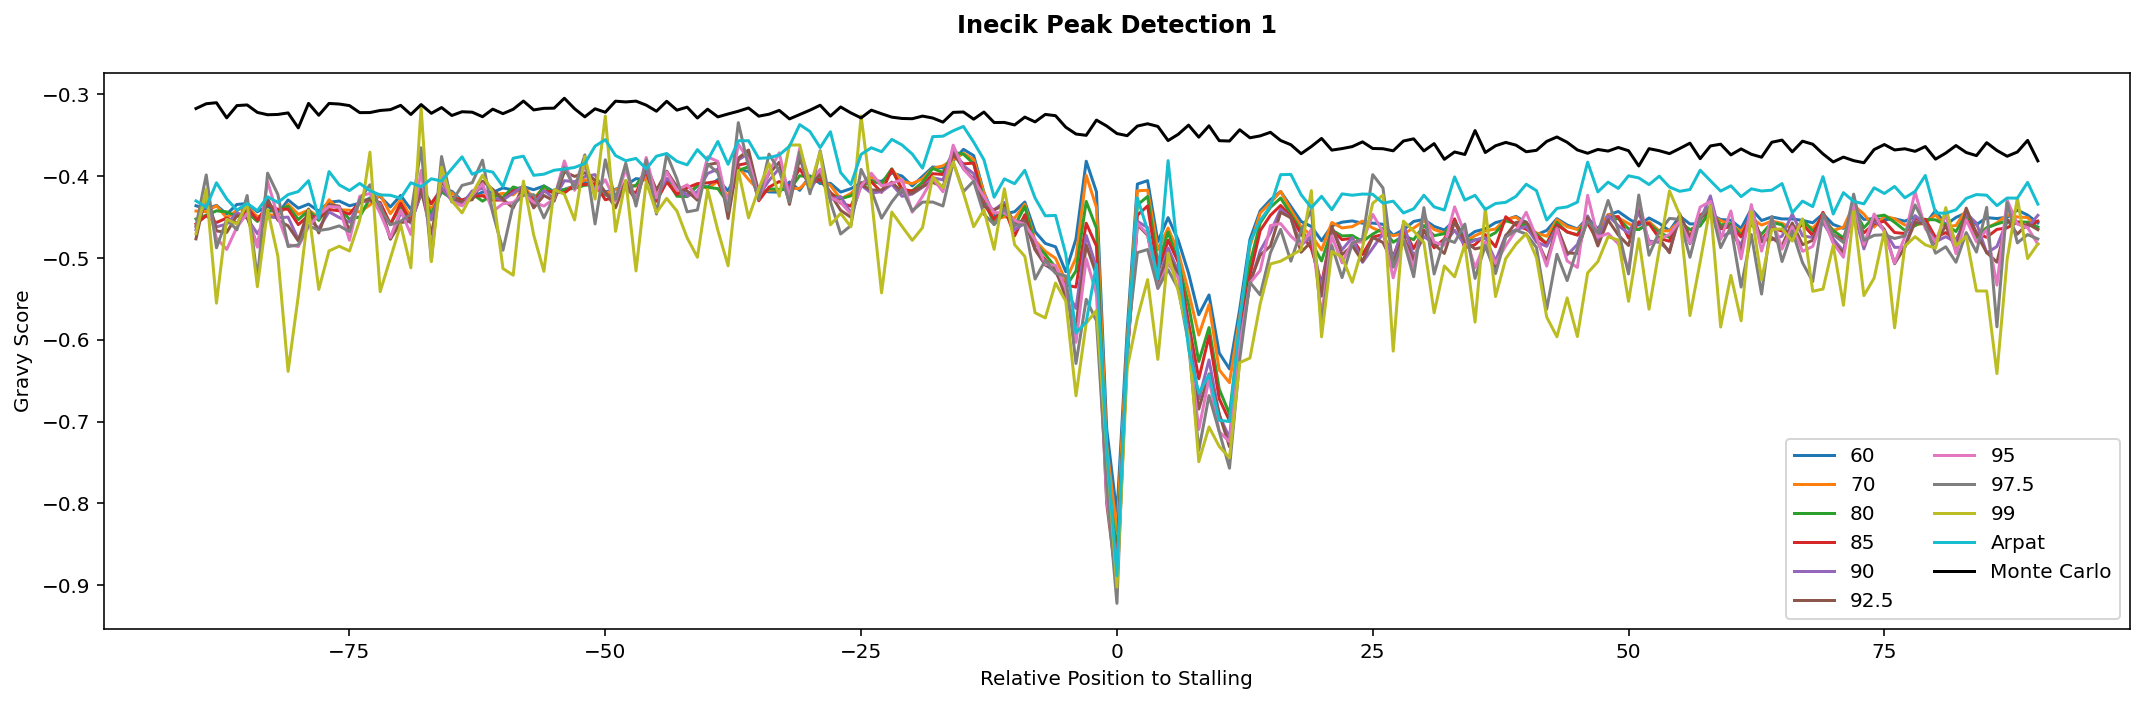

In [8]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, gravy_scores[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, gravy_scores[4], label="Arpat")
plt.plot(x, gravy_scores[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Gravy Score")
plt.tight_layout()
plt.show()

## Molecular Weight

In [9]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Inecik Methods
molwei = list()
for k in range(4):
    molwei_method = list()
    for i in range(len(percentiles)):
        molwei_temp = list()
        W_temp = W[k][i].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_mw = pa.molecular_weight() / len(aminoacids_vertical)
            molwei_temp.append(average_mw)
        molwei_method.append(molwei_temp)
    molwei.append(molwei_method)
# Arpat & Monte Carlo
for k in range(4, 6):
    molwei_temp = list()
    W_temp = W[k].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_mw = pa.molecular_weight() / len(aminoacids_vertical)
        molwei_temp.append(average_mw)
    molwei.append(molwei_temp)

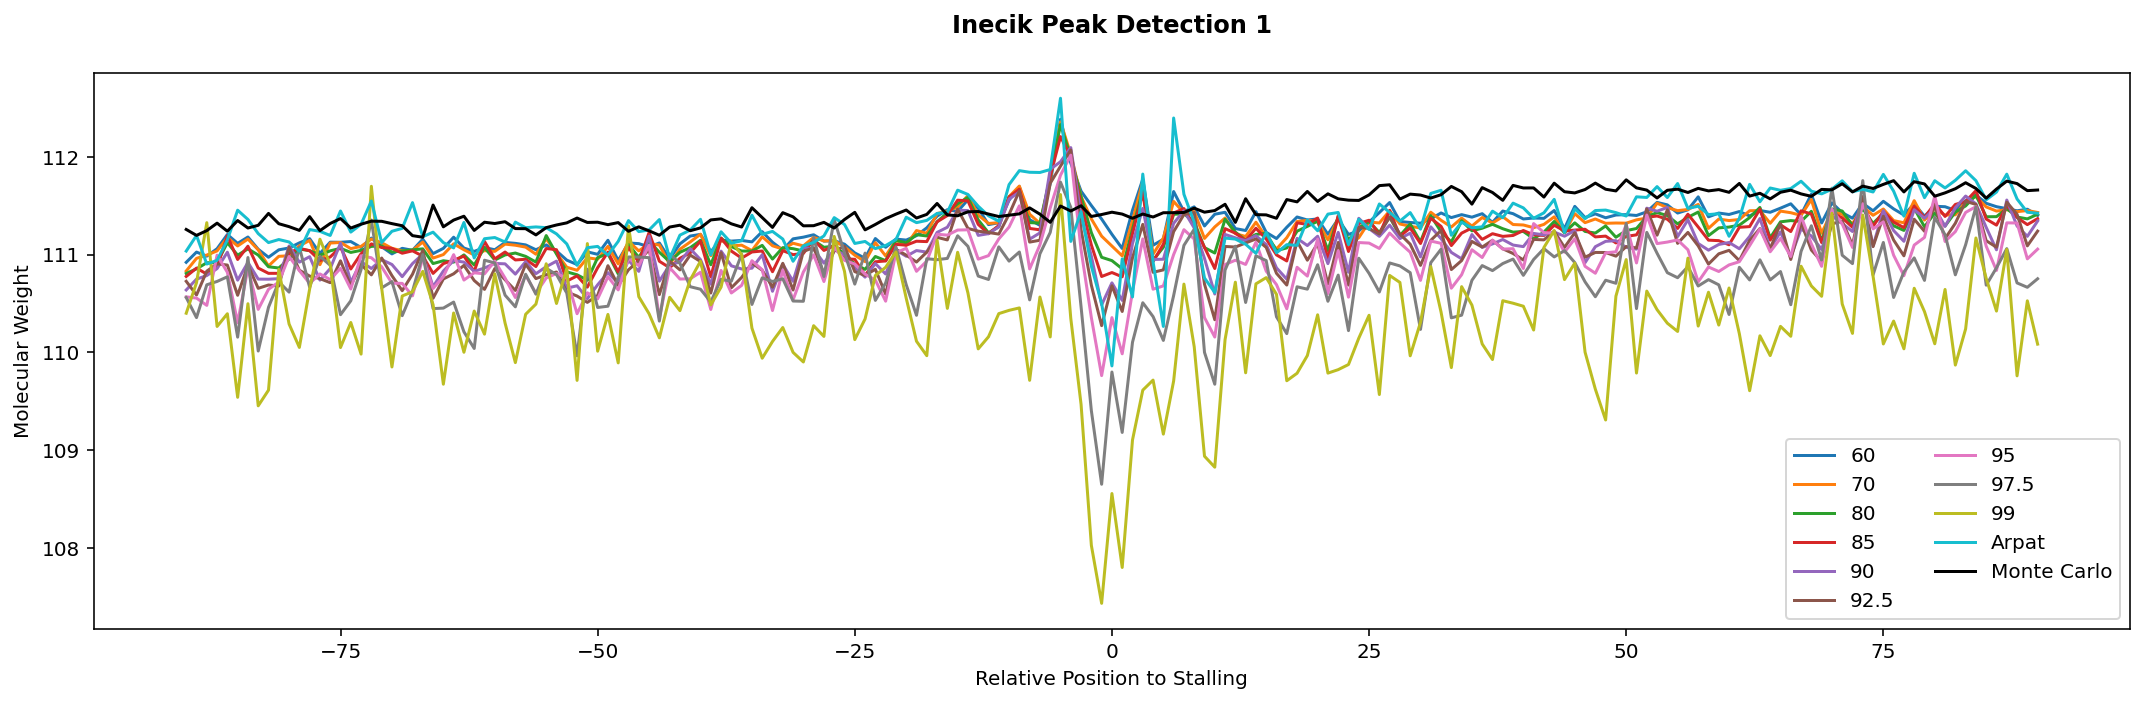

In [10]:
m = 0
fig = plt.figure(figsize=(15,5))
x=np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, molwei[m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, molwei[4], label="Arpat")
plt.plot(x, molwei[5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Molecular Weight")
plt.tight_layout()
plt.show()

## Polarity

## Amino Acid residues

In [11]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def aa_probs(mm="P"):
    # Inecik Methods
    proline = list()
    for k in range(4):
        proline_method = list()
        for i in range(len(percentiles)):
            proline_temp = list()
            W_temp = W[k][i].T
            for j in range(window_len):    
                aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
                pa = ProteinAnalysis(aminoacids_vertical)
                average_proline = pa.get_amino_acids_percent()[mm]
                proline_temp.append(average_proline)
            proline_method.append(proline_temp)
        proline.append(proline_method)
    # Arpat & Monte Carlo
    for k in range(4, 6):
        proline_temp = list()
        W_temp = W[k].T
        for j in range(window_len):
            aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
            pa = ProteinAnalysis(aminoacids_vertical)
            average_proline = pa.get_amino_acids_percent()[mm]
            proline_temp.append(average_proline)
        proline.append(proline_temp)
    return proline
    
aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_amino_acid_probabilities.joblib")
try:  # Because it takes very long, as written very inefficiently.
    aad = joblib.load(save_metadata_path)
except FileNotFoundError:
    executor = multiprocessing.Pool(len(aa))
    result = executor.map(aa_probs, aa)
    executor.terminate()
    executor.join()
    aad = dict(zip(aa, result))
    joblib.dump(aad, save_metadata_path);

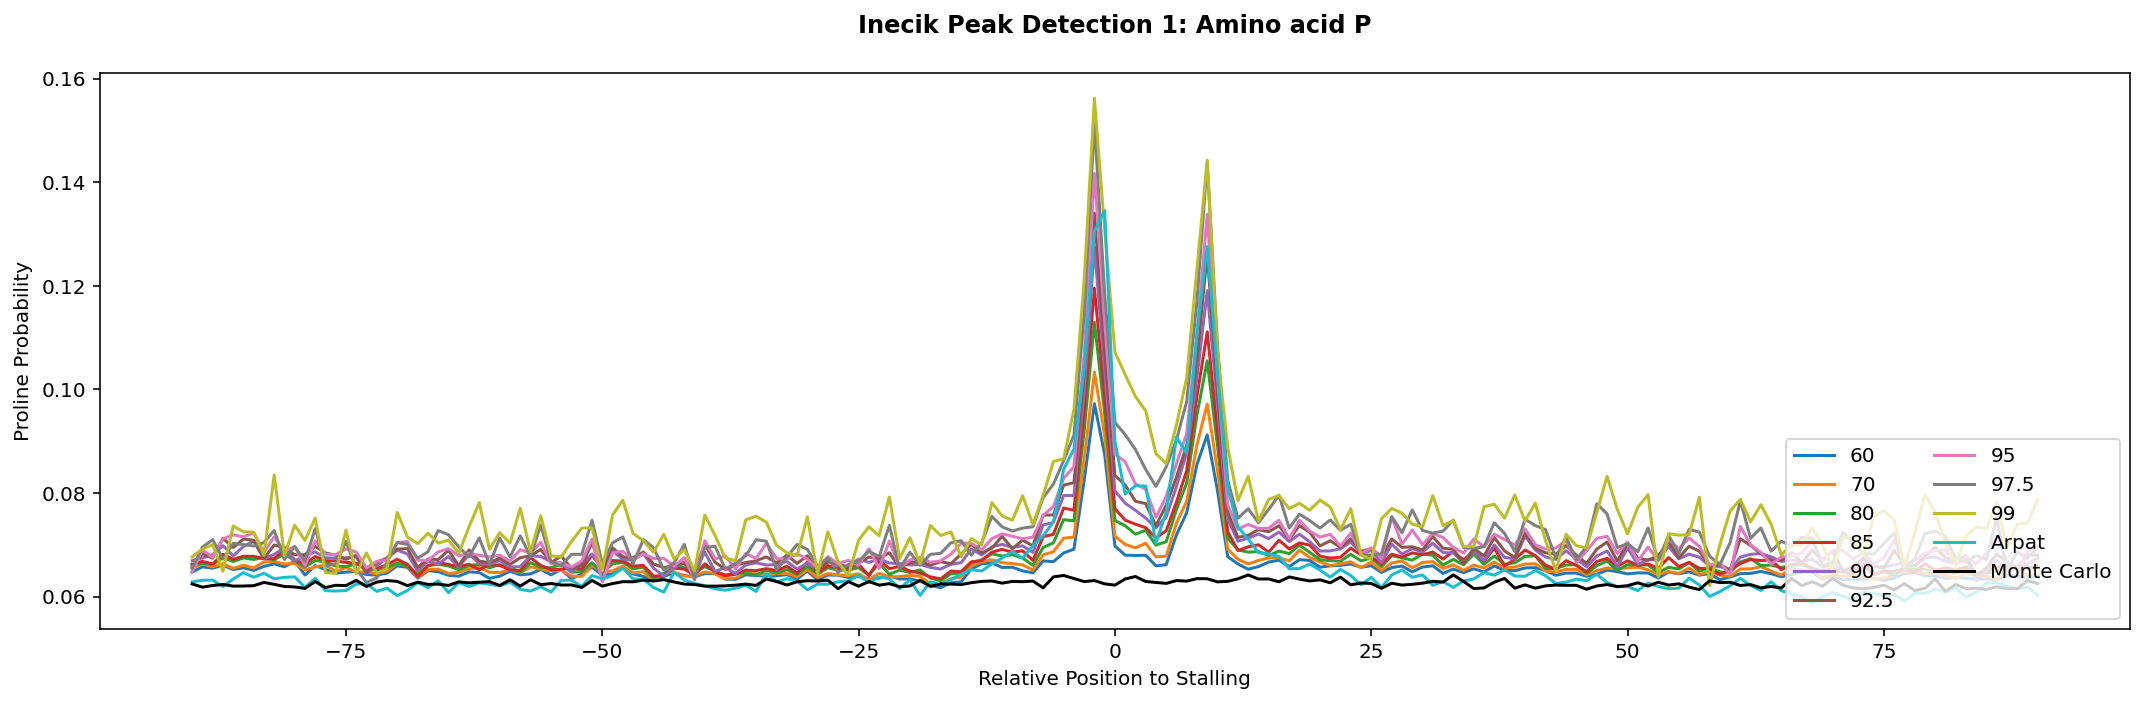

In [12]:
mm = "P"
m = 0
fig = plt.figure(figsize=(15,5))
x = np.arange(-window_flank, window_flank + 1)
for i in range(len(percentiles)):
    plt.plot(x, aad[mm][m][i], label=percentiles[i] if m!=2 else probabilities[i])
plt.plot(x, aad[mm][4], label="Arpat")
plt.plot(x, aad[mm][5], label="Monte Carlo", color="black")
plt.legend(loc="lower right", ncol=2)
plt.title(f"Inecik Peak Detection {m+1}: Amino acid {mm}", y=1.05, fontweight="bold")
plt.xlabel("Relative Position to Stalling")
plt.ylabel("Proline Probability")
plt.tight_layout()
plt.show()

In [13]:
# More accurate objective function

# https://en.wikipedia.org/wiki/Position_weight_matrix
def information_content(aad, inecik_method, perc):  # Relative entropy
    ic = 0
    for mm in aa:  
        observed = np.array(aad[mm][inecik_method][perc])
        expected = np.array(aad[mm][-1])
        ic += - np.log(expected/observed) * observed
    return ic

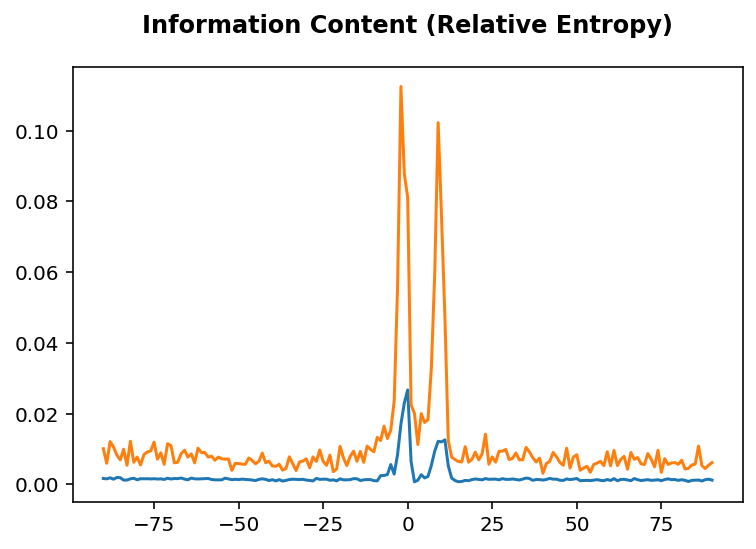

In [14]:
plt.plot(x, information_content(aad, 2, 0))
plt.plot(x, information_content(aad, 2, 8))
plt.title("Information Content (Relative Entropy)", y=1.05, fontweight="bold")
plt.show()

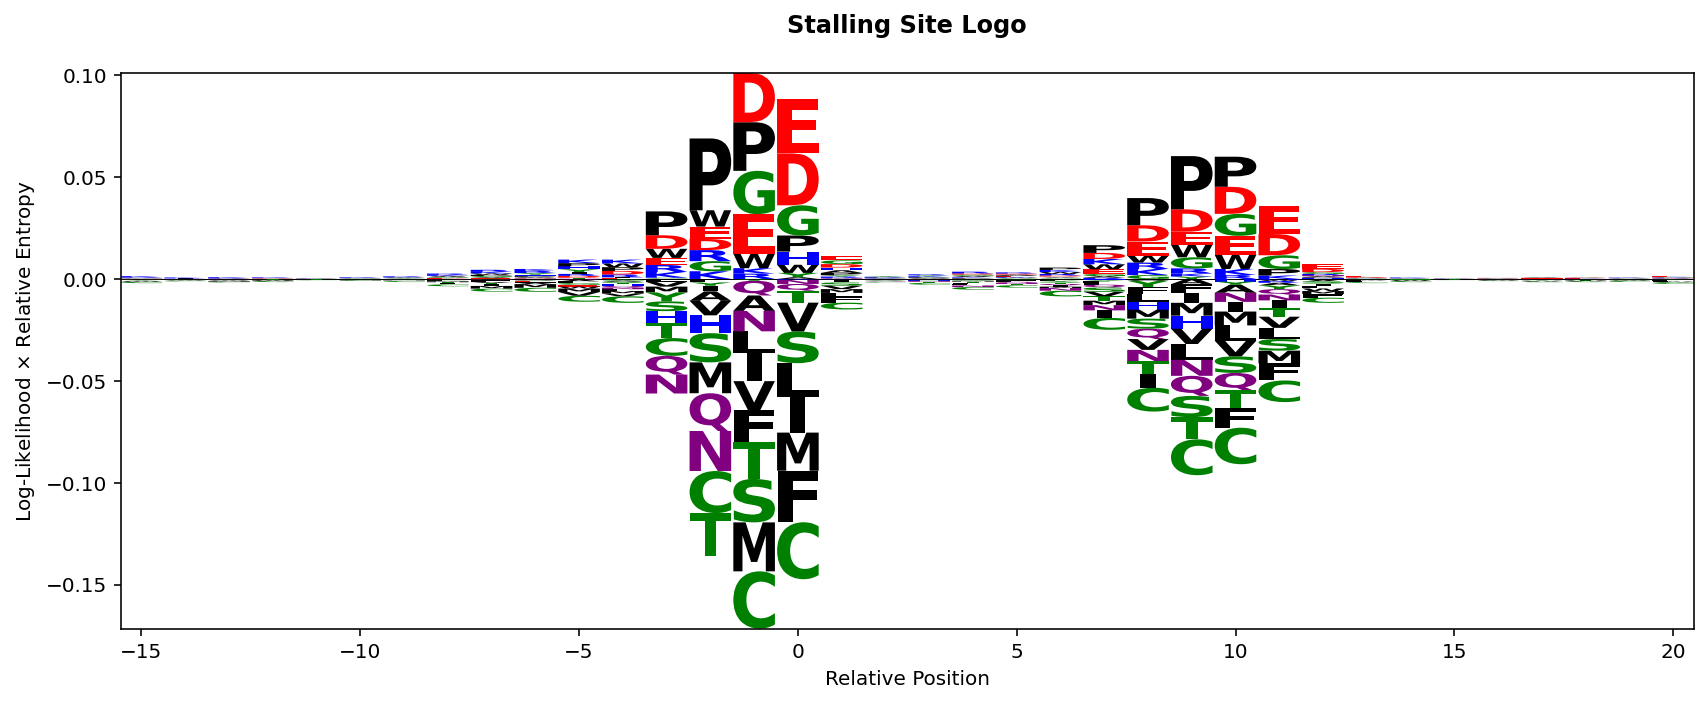

In [15]:
import logomaker
mmaa = list()

ic = information_content(aad, 2, percentiles.index(90))
for mm in aa:
    observed = np.array(aad[mm][2][percentiles.index(90)])
    expected = np.array(aad[mm][5])
    position_weight_matrix = ic * np.log(observed/expected)
    mmaa.append(position_weight_matrix)
    # http://www.bioinformatics.org/blogo/help.htm
    # https://en.wikipedia.org/wiki/Sequence_logo
    # https://en.wikipedia.org/wiki/Position_weight_matrix
ww_df = pd.DataFrame.from_dict(dict(zip(aa, mmaa)))
ww_df.index = np.arange(-window_flank, window_flank + 1)

# Plot
ww_df=ww_df.loc[-15: 20]
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(ww_df, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Log-Likelihood $\times$ Relative Entropy")
ss_logo.ax.set_xlabel("Relative Position")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

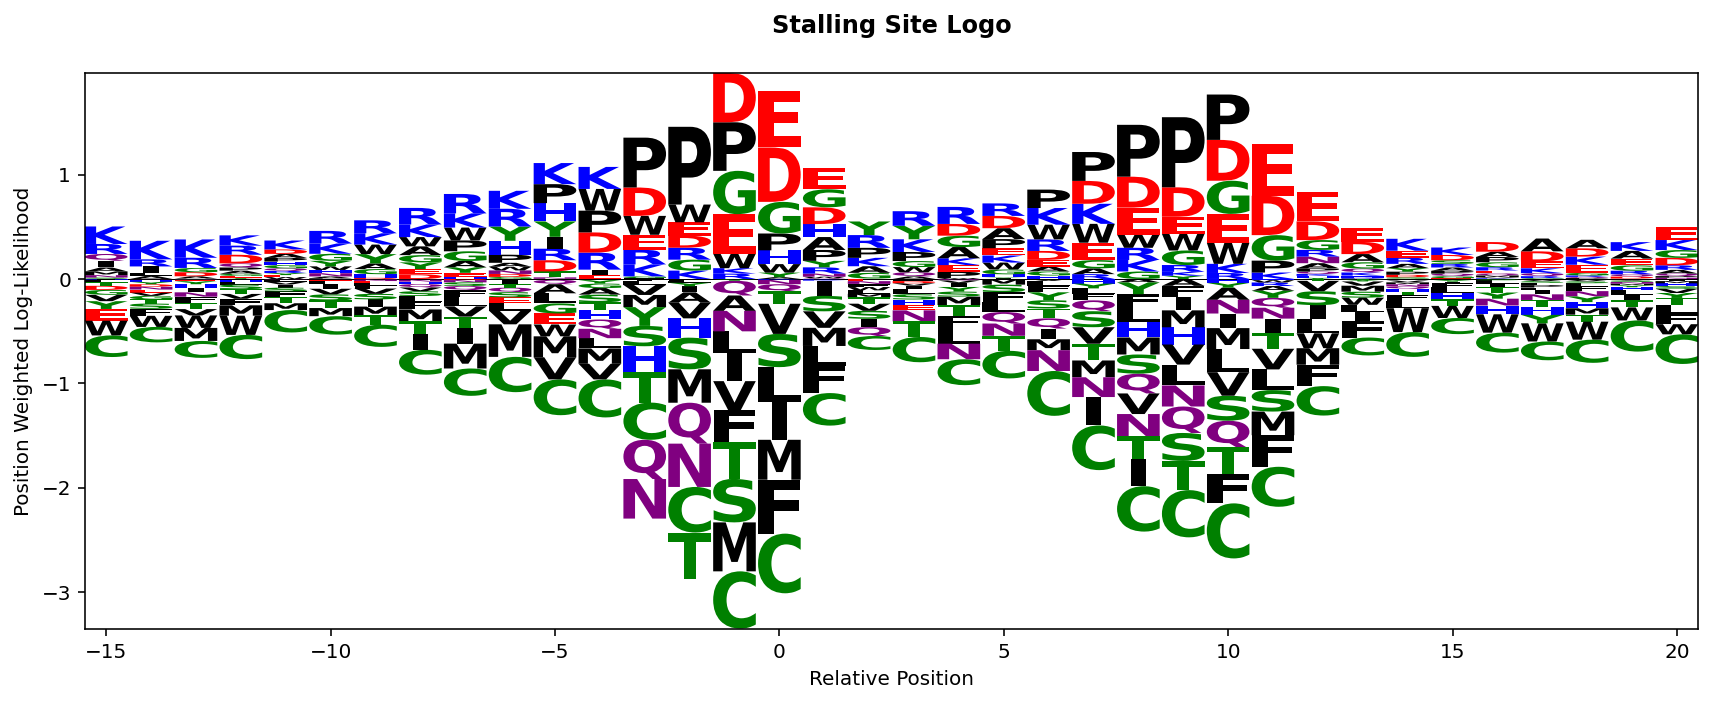

In [16]:
mmaa = list()
for mm in aa:
    observed = np.array(aad[mm][2][percentiles.index(90)])
    expected = np.array(aad[mm][5])
    position_weight_matrix = np.log(observed/expected)
    mmaa.append(position_weight_matrix)
    # http://www.bioinformatics.org/blogo/help.htm
    # https://en.wikipedia.org/wiki/Sequence_logo
    # https://en.wikipedia.org/wiki/Position_weight_matrix
ww_df = pd.DataFrame.from_dict(dict(zip(aa, mmaa)))
ww_df.index = np.arange(-window_flank, window_flank + 1)

# Plot
ww_df=ww_df.loc[-15: 20]
fig, ax = plt.subplots(1,1,figsize=[12,5])
ss_logo = logomaker.Logo(ww_df, flip_below=False, color_scheme='chemistry', ax=ax)
ss_logo.ax.set_ylabel(r"Position Weighted Log-Likelihood")
ss_logo.ax.set_xlabel("Relative Position")
ss_logo.ax.set_title("Stalling Site Logo", y=1.05, fontweight="bold")
plt.tight_layout()
plt.show()

## Method comparison with relative entropy as objective function

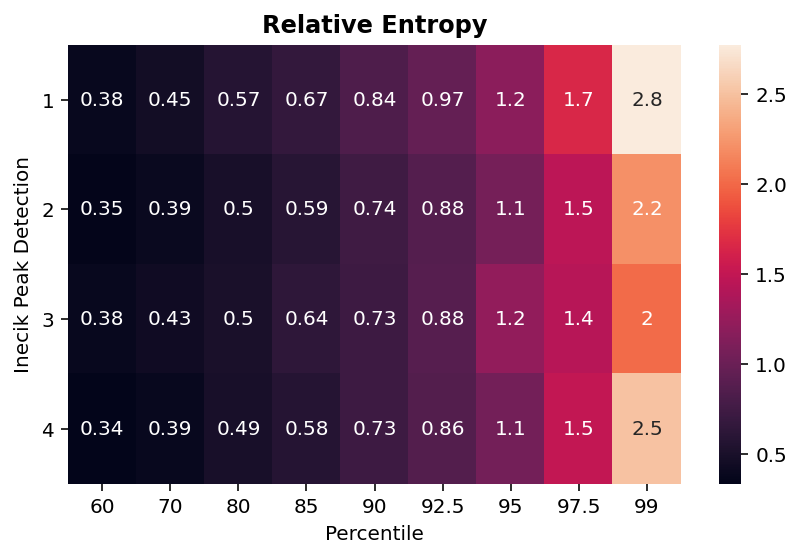

In [17]:
rel_ent = np.zeros((4,len(percentiles)))
for i1 in range(4):
    for i2 in range(len(percentiles)):
        rel_ent[i1, i2] = np.sum(information_content(aad, i1, i2))

import seaborn as sns
heat = sns.heatmap(rel_ent, annot=True, xticklabels=percentiles)
plt.gca().set_yticklabels(range(1,5), rotation=0)
plt.title("Relative Entropy", y=1.1, fontweight="bold")
plt.xlabel("Percentile")
plt.ylabel("Inecik Peak Detection")
plt.tight_layout()
plt.show()

## Scanning wlen and percentile for Inecik 2

In [18]:
from functools import partial
from copy import deepcopy

window_len = 181
window_flank = int(np.floor(window_len / 2))
percentiles_wlen = (70, 80, 85, 90, 92.5, 95, 97.5, 99)
wlens = (10, 15, 20, 30, 50, 150, 500, 1000)
assert window_len % 2 == 1 and window_len >= 3

# Methods
inecik2 = partial(I.riboseq_sixtymers.stalling_peaks_inecik_2, window="hanning", window_len=23, min_rpkm_sixtymers=-1, min_rpkm_translatome=1)

save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_protein_sequences_params_wlen_percentile_inecik2.joblib")
try:  # Because it takes very long, as written very inefficiently.
    W_wlen = joblib.load(save_metadata_path)
except FileNotFoundError:
    gene_list_calc = I.gene_list
    counter = 0
    total_iteration = (len(wlens)) * (len(gene_list_calc))
    windows = [[[] for _ in range(len(percentiles_wlen))] for _ in range(len(wlens))] + [[]]   # inecik1, monte_carlo
    for ind1, wlen in enumerate(wlens):
        for ind3, gene_id in enumerate(gene_list_calc):
            counter += 1
            if counter % 1000 == 1:
                progress_bar(counter, total_iteration, verbose=True, suffix=f"    wlen {ind1 + 1}: {wlen}")
            best_transcript = I.gene_info[gene_id].transcripts.iloc[0][0]  # At least 1 transcript exists
            protein_sequence = I.protein_genome.db[best_transcript][1]
            length_protein = len(protein_sequence)
            assert "." not in protein_sequence
            protein_sequence = "." * window_flank + protein_sequence + "." * window_flank
            # My method
            for ind2, perc in enumerate(percentiles_wlen):
                peaks2 = (np.floor(inecik2(gene_id, percentile=perc, wlen=wlen) / 3) + window_flank).astype(int)
                for peak in peaks2:
                    windows[ind1][ind2].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
            if ind1 == 0:
                # Monte Carlo
                peaks_mc = (np.sort(np.random.choice(length_protein, 10)) + window_flank).astype(int)
                for peak in peaks_mc:
                    windows[-1].append(protein_sequence[peak - window_flank: peak + window_flank + 1])
    # Convert to chararray
    W_wlen = [[None for _ in range(len(percentiles_wlen))] for _ in range(len(wlens))] + [None]
    for wle in range(len(wlens)):
        for per in range(len(percentiles_wlen)):
            W_temp = np.chararray((len(windows[wle][per]), window_len), itemsize=1)
            W_temp[:] = "."
            for ind, peak_window in enumerate(windows[wle][per]):
                W_temp[ind] = list(peak_window)
            W_wlen[wle][per] = W_temp
    # Monte Carlo
    W_temp = np.chararray((len(windows[-1]), window_len), itemsize=1)
    W_temp[:] = "."
    for ind, peak_window in enumerate(windows[-1]):
        W_temp[ind] = list(peak_window)
    W_wlen[-1] = W_temp
    # Return
    del windows
    joblib.dump(W_wlen, save_metadata_path)

In [19]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def aa_probs_wlen(mm="P"):
    # Inecik Methods
    proline = list()
    for k in range(len(wlens)):
        proline_method = list()
        for i in range(len(percentiles_wlen)):
            proline_temp = list()
            W_temp = W_wlen[k][i].T
            for j in range(window_len):    
                aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
                pa = ProteinAnalysis(aminoacids_vertical)
                average_proline = pa.get_amino_acids_percent()[mm]
                proline_temp.append(average_proline)
            proline_method.append(proline_temp)
        proline.append(proline_method)
    # Monte Carlo
    proline_temp = list()
    W_temp = W_wlen[-1].T
    for j in range(window_len):
        aminoacids_vertical = "".join(W_temp[j].decode()).replace(".", "").replace("X", "").replace("U", "")
        pa = ProteinAnalysis(aminoacids_vertical)
        average_proline = pa.get_amino_acids_percent()[mm]
        proline_temp.append(average_proline)
    proline.append(proline_temp)
    return proline

aa = ['C', 'D', 'S', 'Q', 'K', 'I', 'P', 'T', 'F', 'N', 'G', 'H', 'L', 'R', 'W', 'A', 'V', 'E', 'Y', 'M']
save_metadata_path = os.path.join(temp_repo_dir, "jupyter_method_comparison_amino_acid_probabilities_wlen_scan.joblib")
try:  # Because it takes very long, as written very inefficiently.
    aad_wlen = joblib.load(save_metadata_path)
except FileNotFoundError:
    executor = multiprocessing.Pool(len(aa))
    result = executor.map(aa_probs_wlen, aa)
    executor.terminate()
    executor.join()
    aad_wlen = dict(zip(aa, result))
    joblib.dump(aad_wlen, save_metadata_path);

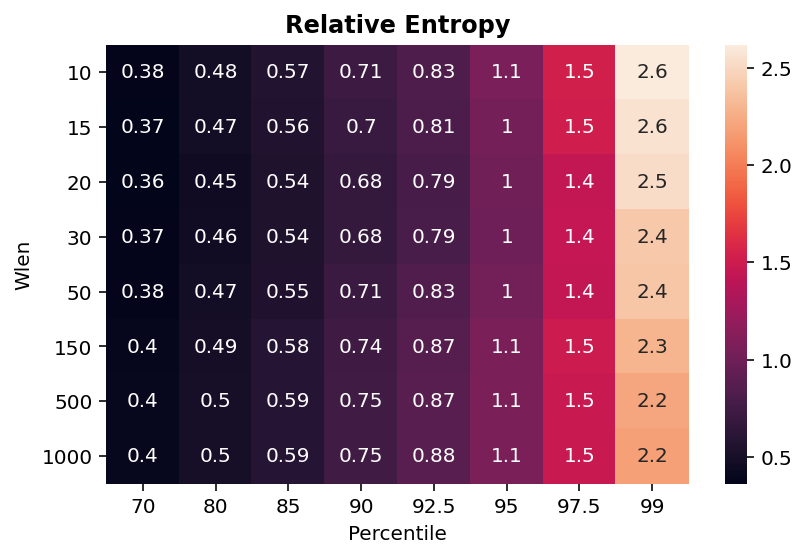

In [27]:
import seaborn as sns
rel_ent = np.zeros((len(wlens),len(percentiles_wlen)))
for i1 in range(len(wlens)):
    for i2 in range(len(percentiles_wlen)):
        rel_ent[i1, i2] = np.sum(information_content(aad_wlen, i1, i2))
        
heat_wlen = sns.heatmap(rel_ent, annot=True, xticklabels=percentiles_wlen)
plt.gca().set_yticklabels(wlens, rotation=0)
plt.title("Relative Entropy", y=1.1, fontweight="bold")
plt.xlabel("Percentile")
plt.ylabel("Wlen")
plt.tight_layout()
plt.show()

In [ ]:
# analayse the regions 92.5-95 arası gibi to pinpoint important peaks

In [22]:
# https://web.expasy.org/protparam/protparam-doc.html
# https://web.expasy.org/protscale/
# https://biopython.org/docs/1.75/api/Bio.SeqUtils.ProtParam.html

In [24]:
# Monte karlo şu olsun: aynı miktarda peak'i seç from a given gene. o monte karlo o percentile'e ait olsun.

In [26]:
# Number of peaks vs objective function grafiği çiz. elbow point'i al.